# Set up

In [ ]:
!pip install -U ffmpeg
!pip install -U youtube-dl

  Created wheel for ffmpeg: filename=ffmpeg-1.4-cp37-none-any.whl size=6084 sha256=942f33272d4a0aca63f3388f581529719e800425d7fae6b005090af92ddf71c5
  Stored in directory: /root/.cache/pip/wheels/b6/68/c3/a05a35f647ba871e5572b9bbfc0b95fd1c6637a2219f959e7a
Successfully built ffmpeg
     |████████████████████████████████| 2.3MB 7.0MB/s 
     |████████████████████████████████| 1.9MB 5.4MB/s 


In [ ]:
!git clone https://github.com/commaai/speedchallenge.git
!git clone https://github.com/jovsa/speed-challenge-2017.git  

Cloning into 'speedchallenge'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 14 (delta 0), reused 0 (delta 0), pack-reused 11
Unpacking objects: 100% (14/14), done.
Cloning into 'speed-challenge-2017'...
remote: Enumerating objects: 110, done.
remote: Total 110 (delta 0), reused 0 (delta 0), pack-reused 110
Receiving objects: 100% (110/110), 18.71 MiB | 25.85 MiB/s, done.
Resolving deltas: 100% (37/37), done.


In [ ]:
!rm speedchallenge/data/train.mp4
!youtube-dl -f mp4 -o speedchallenge/data/train.mp4 https://youtu.be/LMJHVc3fpo4
!rm speedchallenge/data/test.mp4
!youtube-dl -f mp4 -o speedchallenge/data/test.mp4 https://youtu.be/FcAbi_mutTA

[youtube] LMJHVc3fpo4: Downloading webpage
[youtube] LMJHVc3fpo4: Downloading MPD manifest
[download] Destination: speedchallenge/data/train.mp4
[download] 100% of 49.39MiB in 00:01
[youtube] FcAbi_mutTA: Downloading webpage
[youtube] FcAbi_mutTA: Downloading MPD manifest
[download] Destination: speedchallenge/data/test.mp4
[download] 100% of 28.50MiB in 00:00


# Constants

In [ ]:
# constants
DATA_PATH = 'speedchallenge/data'
TRAIN_VIDEO = os.path.join(DATA_PATH, 'train.mp4') #'drive.mp4' 'train.mp4'
TEST_VIDEO = os.path.join(DATA_PATH, 'test.mp4')
!mkdir speed-challenge-2017/clean_data
!mkdir speed-challenge-2017/clean_data/train_imgs
CLEAN_DATA_PATH = 'speed-challenge-2017/clean_data'
CLEAN_IMGS_TRAIN = os.path.join(CLEAN_DATA_PATH, 'train_imgs') #train2_imgs train_imgs
CLEAN_IMGS_TEST = os.path.join(CLEAN_DATA_PATH, 'test_imgs')
ASSETS_PATH = 'speed-challenge-2017/assets'

train_frames = 20400 #8616 #20400 #8616
test_frames = 10798

seeds = [1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144]


# hyperparameters
batch_size = 16
num_epochs = 25 #100 #90 
steps_per_epoch = 400

# run specific constants
model_name = 'nvidia' #nvidia2
run_name = 'model={}-batch_size={}-num_epoch={}-steps_per_epoch={}'.format(model_name,
                                                                          batch_size,
                                                                          num_epochs,
                                                                          steps_per_epoch)

assets_filepath = os.path.join(ASSETS_PATH, 'model_assets' , run_name)
weights_loc = os.path.join(assets_filepath,'weights.h5')
history_loc=  os.path.join(assets_filepath,'history.p')
tensorboard_loc = os.path.join(assets_filepath, run_name)



In [ ]:
run_name

'model=nvidia-batch_size=16-num_epoch=25-steps_per_epoch=400'

# Dataset Construction

In [ ]:
train_y = list(pd.read_csv(os.path.join(DATA_PATH, 'train.txt'), header=None, squeeze=True))
assert(len(train_y)==train_frames)

In [ ]:
def dataset_constructor(video_loc, img_folder, tot_frames, dataset_type):
  class getFrames():
    def __init__(self):
      self.vid = cv2.VideoCapture(video_loc)
    def __iter__(self):
      return self
    def __next__(self):
      con, frame = self.vid.read()
      if con:
        return frame
      else:
        raise StopIteration
    def __len__(self):
      return int(self.vid.get(cv2.CAP_PROP_FRAME_COUNT))

  meta_dict = {}

  tqdm.write('reading in video file...')
  tot_frames = train_frames
  #cap = skvideo.io.vread(video_loc)
    
  tqdm.write('constructing dataset...')
  #for idx, frame in enumerate(tqdm(cap)):
  for idx, frame in enumerate(tqdm(getFrames())):
    img_path = os.path.join(img_folder, str(idx)+'.jpg')
    frame_speed = float('NaN') if dataset_type == 'test' else train_y[idx]
    meta_dict[idx] = [img_path, idx, frame_speed]
    #skvideo.io.vwrite(img_path, frame)
    cv2.imwrite(img_path, frame) 
  meta_df = pd.DataFrame.from_dict(meta_dict, orient='index')
  meta_df.columns = ['image_path', 'image_index', 'speed']
  
  tqdm.write('writing meta to csv')
  meta_df.to_csv(os.path.join(CLEAN_DATA_PATH, dataset_type+'_meta.csv'), index=False)
  
  return "done dataset_constructor"

In [ ]:
# train data
dataset_constructor(TRAIN_VIDEO, CLEAN_IMGS_TRAIN, train_frames, 'train')

reading in video file...
constructing dataset...



writing meta to csv


'done dataset_constructor'

In [ ]:
train_meta = pd.read_csv(os.path.join(CLEAN_DATA_PATH, 'train_meta.csv'))
#assert(train_meta.shape[0] == train_frames)
assert(train_meta.shape[1] == 3)

In [ ]:
train_meta.head()

,image_path,image_index,speed
0,speed-challenge-2017/clean_data/train_imgs/0.jpg,0,28.105569
1,speed-challenge-2017/clean_data/train_imgs/1.jpg,1,28.105569
2,speed-challenge-2017/clean_data/train_imgs/2.jpg,2,28.106527
3,speed-challenge-2017/clean_data/train_imgs/3.jpg,3,28.130404
4,speed-challenge-2017/clean_data/train_imgs/4.jpg,4,28.109243


In [ ]:
for i in range(50):
  print('speed:',train_meta['speed'][i] )
  img=mpimg.imread(train_meta['image_path'][i])
  print('shape:', img.shape)
  plt.imshow(img)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

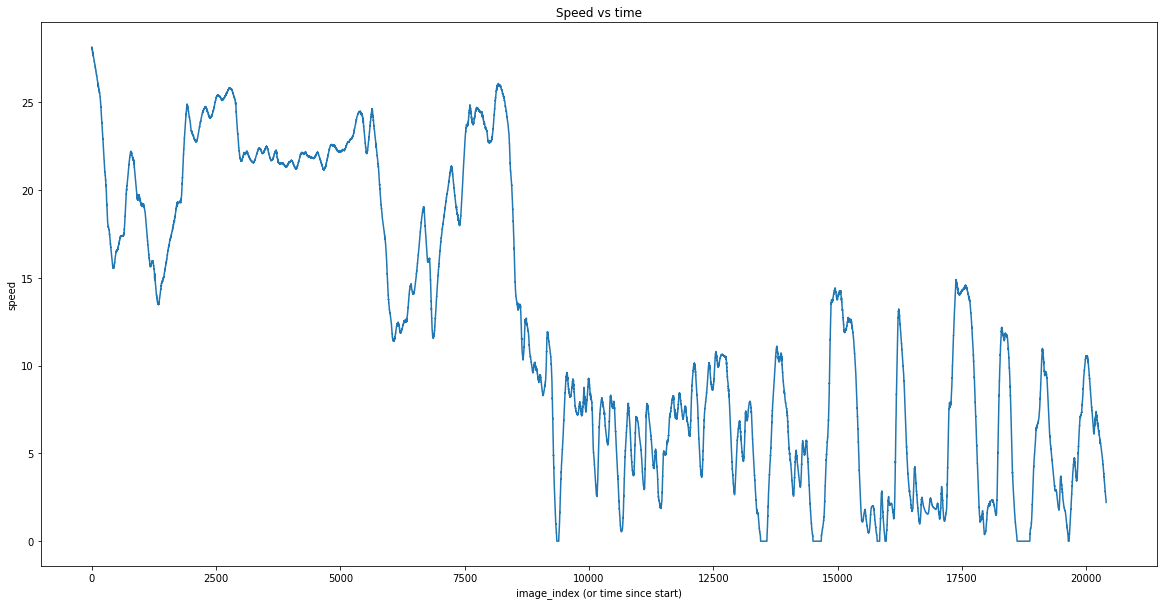

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(train_meta['speed'])
plt.xlabel('image_index (or time since start)')
plt.ylabel('speed')
plt.title('Speed vs time')
plt.show()

# Training the Model

In [ ]:
train_meta = pd.read_csv(os.path.join(CLEAN_DATA_PATH, 'train_meta.csv')) #train2_meta
print('shape: ', train_meta.shape)

shape:  (20400, 3)


In [ ]:
# note: there is a chance that points might appear again. as n

def train_valid_split(dframe, seed_val):
    """
    Randomly shuffle pairs of rows in the dataframe, separates train and validation data
    generates a uniform random variable 0->9, gives 20% chance to append to valid data, otherwise train_data
    return tuple (train_data, valid_data) dataframes
    """
    train_data = pd.DataFrame()
    valid_data = pd.DataFrame()
    np.random.seed(seed_val)
    for i in tqdm(range(len(dframe) - 1)):
        idx1 = np.random.randint(len(dframe) - 1)
        idx2 = idx1 + 1
        
        
        row1 = dframe.iloc[[idx1]].reset_index()
        row2 = dframe.iloc[[idx2]].reset_index()
        
        randInt = np.random.randint(9)
        if 0 <= randInt <= 1:
            valid_frames = [valid_data, row1, row2]
            valid_data = pd.concat(valid_frames, axis = 0, join = 'outer', ignore_index=False)
        if randInt >= 2:
            train_frames = [train_data, row1, row2]
            train_data = pd.concat(train_frames, axis = 0, join = 'outer', ignore_index=False)
    return train_data, valid_data

In [ ]:
train_data, valid_data = train_valid_split(train_meta, seeds[0])

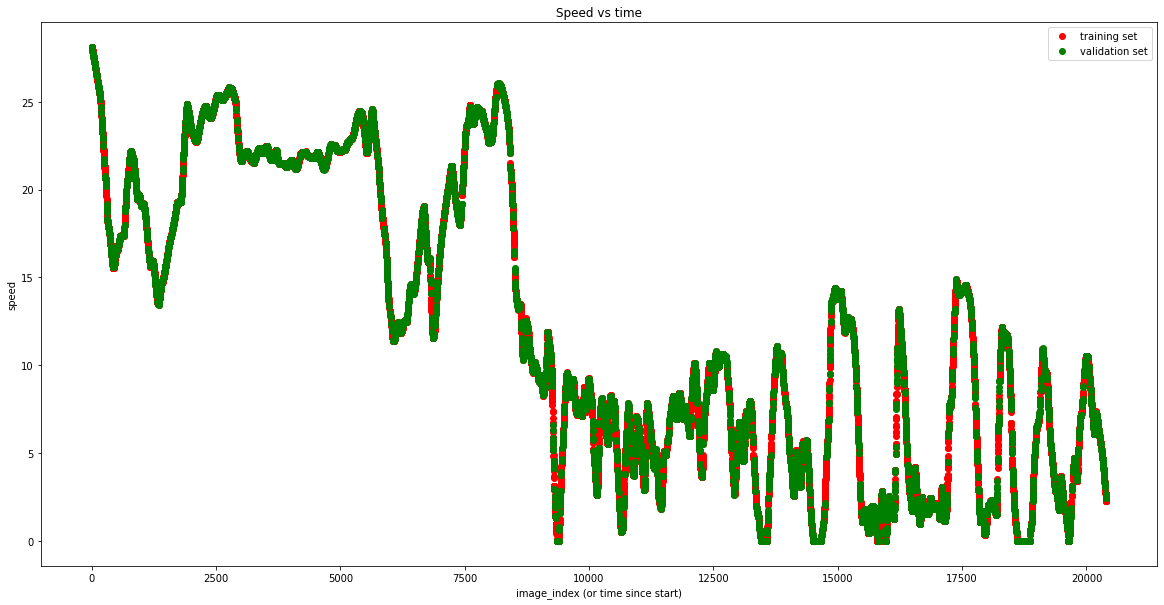

----
valid_data:  (9032, 4)
train_data:  (31766, 4)


In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(train_data.sort_values(['image_index'])[['image_index']], train_data.sort_values(['image_index'])[['speed']], 'ro')
plt.plot(valid_data.sort_values(['image_index'])[['image_index']], valid_data.sort_values(['image_index'])[['speed']], 'go')
plt.xlabel('image_index (or time since start)')
plt.ylabel('speed')
plt.title('Speed vs time')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()
plt.close()

print('----')
print('valid_data: ', valid_data.shape)
print('train_data: ', train_data.shape)

In [ ]:
def change_brightness(image, bright_factor):
    """
    Augments the brightness of the image by multiplying the saturation by a uniform random variable
    Input: image (RGB)
    returns: image with brightness augmentation
    """
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # perform brightness augmentation only on the second channel
    hsv_image[:,:,2] = hsv_image[:,:,2] * bright_factor
    
    # change back to RGB
    image_rgb = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    return image_rgb

In [ ]:
# img=mpimg.imread(train_meta['image_path'][60])
# print('original image shape:', img.shape)
# plt.imshow(img)
# plt.show()
# plt.close()

# bright_factor = 0.7 + np.random.uniform()
# print('bright_factor:', bright_factor)
# print('brightned image')
# img=mpimg.imread(train_meta['image_path'][60])
# plt.imshow(change_brightness(img, bright_factor))
# plt.show()
# plt.close()

In [ ]:
def opticalFlowDense(image_current, image_next):
    """
    input: image_current, image_next (RGB images)
    calculates optical flow magnitude and angle and places it into HSV image
    * Set the saturation to the saturation value of image_next
    * Set the hue to the angles returned from computing the flow params
    * set the value to the magnitude returned from computing the flow params
    * Convert from HSV to RGB and return RGB image with same size as original image
    """
    gray_current = cv2.cvtColor(image_current, cv2.COLOR_RGB2GRAY)
    gray_next = cv2.cvtColor(image_next, cv2.COLOR_RGB2GRAY)
    
    
    hsv = np.zeros((66, 220, 3))
    # set saturation
    hsv[:,:,1] = cv2.cvtColor(image_next, cv2.COLOR_RGB2HSV)[:,:,1]
 
    # Flow Parameters
#     flow_mat = cv2.CV_32FC2
    flow_mat = None
    image_scale = 0.5
    nb_images = 1
    win_size = 15
    nb_iterations = 2
    deg_expansion = 5
    STD = 1.3
    extra = 0

    # obtain dense optical flow paramters
    flow = cv2.calcOpticalFlowFarneback(gray_current, gray_next,  
                                        flow_mat, 
                                        image_scale, 
                                        nb_images, 
                                        win_size, 
                                        nb_iterations, 
                                        deg_expansion, 
                                        STD, 
                                        0)
                                        
        
    # convert from cartesian to polar
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])  
        
    # hue corresponds to direction
    hsv[:,:,0] = ang * (180/ np.pi / 2)
    
    # value corresponds to magnitude
    hsv[:,:,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    
    # convert HSV to float32's
    hsv = np.asarray(hsv, dtype= np.float32)
    rgb_flow = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)

    
    return rgb_flow

In [ ]:
def preprocess_image(image):
    """
    preprocesses the image
    
    input: image (480 (y), 640 (x), 3) RGB
    output: image (shape is (220, 66, 3) as RGB)
    
    This stuff is performed on my validation data and my training data
    Process: 
             1) Cropping out black spots
             3) resize to (220, 66, 3) if not done so already from perspective transform
    """
    # Crop out sky (top) (100px) and black right part (-90px)
    #image_cropped = image[100:440, :-90] # -> (380, 550, 3) #v2 for data
    image_cropped = image[25:375, :] #v1 for data
    
    image = cv2.resize(image_cropped, (220, 66), interpolation = cv2.INTER_AREA)
    
    return image


# def preprocess_image_2(image):
#     """
#     preprocesses the image
    
#     input: image (480 (y), 640 (x), 3) RGB
#     output: image (shape is (220, 66, 3) as RGB)
    
#     This stuff is performed on my validation data and my training data
#     Process: 
#              1) Cropping out black spots
#              3) resize to (220, 66, 3) if not done so already from perspective transform
#     """
#     # Crop out sky (top) (100px) and black right part (-90px)
#     image_cropped = image[30:400, :-90] # -> (380, 550, 3)
    
#     image = cv2.resize(image_cropped, (220, 66), interpolation = cv2.INTER_AREA)
    
#     return image

original image shape: (360, 480, 3)


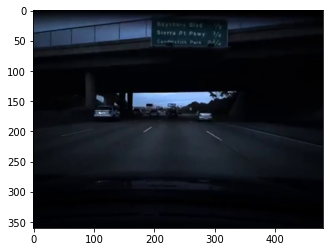

post prosessed image: (66, 220, 3)


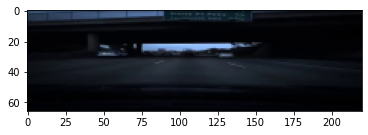

In [ ]:
img=mpimg.imread(train_meta['image_path'][10])
print('original image shape:', img.shape)
plt.imshow(img)
plt.show()
plt.close()

post_img = preprocess_image(img)
print('post prosessed image:', post_img.shape)
plt.imshow(post_img)
plt.show()
plt.close()

In [ ]:
def preprocess_image_valid_from_path(image_path, speed):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = preprocess_image(img)
    return img, speed

def preprocess_image_from_path(image_path, speed, bright_factor):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = change_brightness(img, bright_factor)    
    img = preprocess_image(img)
    return img, speed

In [ ]:
def generate_training_data(data, batch_size = 32):
    image_batch = np.zeros((batch_size, 66, 220, 3)) # nvidia input params
    label_batch = np.zeros((batch_size))
    while True:
        for i in range(batch_size):
            # generate a random index with a uniform random distribution from 1 to len - 1
            idx = np.random.randint(1, len(data) - 1)
            
            # Generate a random bright factor to apply to both images
            bright_factor = 0.2 + np.random.uniform()
            
            row_now = data.iloc[[idx]].reset_index()
            row_prev = data.iloc[[idx - 1]].reset_index()
            row_next = data.iloc[[idx + 1]].reset_index()
            
            # Find the 3 respective times to determine frame order (current -> next)
            
            time_now = row_now['image_index'].values[0]
            time_prev = row_prev['image_index'].values[0]
            time_next = row_next['image_index'].values[0]
            
            if abs(time_now - time_prev) == 1 and time_now > time_prev:
                row1 = row_prev
                row2 = row_now
                
            elif abs(time_next - time_now) == 1 and time_next > time_now:
                row1 = row_now
                row2 = row_next
            else:
                print('Error generating row')            
            
            x1, y1 = preprocess_image_from_path(row1['image_path'].values[0],
                                                row1['speed'].values[0],
                                               bright_factor)
            
            # preprocess another image
            x2, y2 = preprocess_image_from_path(row2['image_path'].values[0], 
                                                row2['speed'].values[0],
                                               bright_factor)
           
            # compute optical flow send in images as RGB
            rgb_diff = opticalFlowDense(x1, x2)
                        
            # calculate mean speed
            y = np.mean([y1, y2])
            
            image_batch[i] = rgb_diff
            label_batch[i] = y
        
        #print('image_batch', image_batch.shape, ' label_batch', label_batch)
        # Shuffle the pairs before they get fed into the network
        #yield shuffle(image_batch, label_batch)
        yield tuple(shuffle(image_batch, label_batch))

In [ ]:
def generate_validation_data(data):
    while True:
        for idx in shuffle(range(1, len(data) - 1)): # start from the second row because we may try to grab it and need its prev to be in bounds
            row_now = data.iloc[[idx]].reset_index()
            row_prev = data.iloc[[idx - 1]].reset_index()
            row_next = data.iloc[[idx + 1]].reset_index()
            
            # Find the 3 respective times to determine frame order (current -> next)
            
            time_now = row_now['image_index'].values[0]
            time_prev = row_prev['image_index'].values[0]
            time_next = row_next['image_index'].values[0]
            
            if abs(time_now - time_prev) == 1 and time_now > time_prev:
                row1 = row_prev
                row2 = row_now
                
            elif abs(time_next - time_now) == 1 and time_next > time_now:
                row1 = row_now
                row2 = row_next
            else:
                print('Error generating row')        
            
            x1, y1 = preprocess_image_valid_from_path(row1['image_path'].values[0], row1['speed'].values[0])
            x2, y2 = preprocess_image_valid_from_path(row2['image_path'].values[0], row2['speed'].values[0])
            
            img_diff = opticalFlowDense(x1, x2)
            img_diff = img_diff.reshape(1, img_diff.shape[0], img_diff.shape[1], img_diff.shape[2])
            y = np.mean([y1, y2])
            
            speed = np.array([[y]])
            
            #print('img_diff', img_diff.shape, ' speed', speed)
            yield (img_diff, speed)

In [ ]:
N_img_height = 66
N_img_width = 220
N_img_channels = 3
def nvidia_model():
    inputShape = (N_img_height, N_img_width, N_img_channels)

    model = Sequential()
    # normalization    
    # perform custom normalization before lambda layer in network
    model.add(Lambda(lambda x: x/ 127.5 - 1, input_shape = inputShape))

    model.add(Convolution2D(24, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv1'))
    
    
    model.add(ELU())    
    model.add(Convolution2D(36, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv2'))
    
    model.add(ELU())    
    model.add(Convolution2D(48, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv3'))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Convolution2D(64, (3, 3), 
                            strides = (1,1), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv4'))
    
    model.add(ELU())              
    model.add(Convolution2D(64, (3, 3), 
                            strides= (1,1), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv5'))
              
              
    model.add(Flatten(name = 'flatten'))
    model.add(ELU())
    model.add(Dense(100, kernel_initializer = 'he_normal', name = 'fc1'))
    model.add(ELU())
    model.add(Dense(50, kernel_initializer = 'he_normal', name = 'fc2'))
    model.add(ELU())
    model.add(Dense(10, kernel_initializer = 'he_normal', name = 'fc3'))
    model.add(ELU())
    
    # do not put activation at the end because we want to exact output, not a class identifier
    model.add(Dense(1, name = 'output', kernel_initializer = 'he_normal'))
    
    adam = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer = adam, loss = 'mse')

    return model

In [ ]:
if not os.path.exists(assets_filepath):
    os.makedirs(assets_filepath)

In [ ]:
valid_generator = generate_validation_data(valid_data)
val_size = len(valid_data.index)

earlyStopping = EarlyStopping(monitor='val_loss', 
                              patience=2, 
                              verbose=1, 
                              min_delta = 0.25,
                              mode='min',)

modelCheckpoint = ModelCheckpoint(weights_loc, 
                                  monitor = 'val_loss', 
                                  save_best_only = True, 
                                  mode = 'min', 
                                  verbose = 1,
                                 save_weights_only = True)

tensorboard = TensorBoard(log_dir=tensorboard_loc, histogram_freq=0,
                            write_graph=True, write_images=True)

callbacks_list = [modelCheckpoint, tensorboard, earlyStopping]

In [ ]:
val_size

9032

In [ ]:
model = nvidia_model()
model

Load previous weights for fine-tuning

In [ ]:
model.load_weights(weights_loc)

In [ ]:
train_size = len(train_data.index)
train_generator = generate_training_data(train_data, batch_size)
history = model.fit(
        train_generator, 
        steps_per_epoch = steps_per_epoch, 
        epochs = num_epochs,
        callbacks = callbacks_list,
        verbose = 1,
        validation_data = valid_generator,
        validation_steps = val_size
        )

print(history)

Epoch 1/25
400/400 [==============================] - 393s 984ms/step - loss: 25.1838 - val_loss: 19.7740

Epoch 00001: val_loss improved from inf to 19.77404, saving model to speed-challenge-2017/assets/model_assets/model=nvidia-batch_size=16-num_epoch=25-steps_per_epoch=400/weights.h5
Epoch 2/25
400/400 [==============================] - 390s 978ms/step - loss: 17.5452 - val_loss: 14.4452

Epoch 00002: val_loss improved from 19.77404 to 14.44518, saving model to speed-challenge-2017/assets/model_assets/model=nvidia-batch_size=16-num_epoch=25-steps_per_epoch=400/weights.h5
Epoch 3/25
400/400 [==============================] - 380s 953ms/step - loss: 15.5268 - val_loss: 13.4135

Epoch 00003: val_loss improved from 14.44518 to 13.41350, saving model to speed-challenge-2017/assets/model_assets/model=nvidia-batch_size=16-num_epoch=25-steps_per_epoch=400/weights.h5
Epoch 4/25
400/400 [==============================] - 388s 971ms/step - loss: 13.1818 - val_loss: 12.9383

Epoch 00004: val_lo

In [ ]:
# saving history
pickle.dump(history.history, open(history_loc, "wb"))

# Post Analysis

In [ ]:
# model processing hyperparameters
batch_size = 16
num_epochs = 25 #100 #90 
steps_per_epoch = 400

# run specific constants
model_name = 'nvidia' #nvidia2
run_name = 'model={}-batch_size={}-num_epoch={}-steps_per_epoch={}'.format(model_name,
                                                                          batch_size,
                                                                          num_epochs,
                                                                          steps_per_epoch)

assets_filepath = os.path.join(ASSETS_PATH, 'model_assets' , run_name)
weights_loc = os.path.join(assets_filepath,'weights.h5')
history_loc=  os.path.join(assets_filepath,'history.p')
tensorboard_loc = os.path.join(assets_filepath, run_name)

In [ ]:
history = pickle.load(open(history_loc, "rb" ))
model.load_weights(weights_loc)
adam = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer = adam, loss = 'mse')

In [ ]:
val_score = model.evaluate(valid_generator, steps=val_size)
print('val score:', val_score)

In [ ]:
### plot the training and validation loss for each epoch
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(history['loss'], 'ro--')
plt.plot(history['val_loss'], 'go--')
plt.title('NVIDIA mean squared error loss per epochs')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()
plt.close()

In [ ]:
def make_predictions(data):
    for idx in tqdm(range(1, len(data.index)-1)):
        row_now = data.iloc[[idx]].reset_index()
        row_prev = data.iloc[[idx - 1]].reset_index()
        row_next = data.iloc[[idx + 1]].reset_index()
        
        time_now = row_now['image_index'].values[0]
        time_prev = row_prev['image_index'].values[0]
        time_next = row_next['image_index'].values[0]
        
        if abs(time_now - time_prev) == 1 and time_now > time_prev:
            row1 = row_prev
            row2 = row_now
        elif abs(time_next - time_now) == 1 and time_next > time_now:
            row1 = row_now
            row2 = row_next
        else:
            print('Error generating row')
        
        x1, y1 = preprocess_image_valid_from_path(row1['image_path'].values[0], row1['speed'].values[0])
        x2, y2 = preprocess_image_valid_from_path(row2['image_path'].values[0], row2['speed'].values[0])
        
        img_diff = opticalFlowDense(x1, x2)
        img_diff = img_diff.reshape(1, img_diff.shape[0], img_diff.shape[1], img_diff.shape[2])
        y = np.mean([y1, y2])

        prediction = model.predict(img_diff)
        error = abs(prediction-y2)
        
        
        #print(prediction, error, time_now)
        data.loc[data['image_index']==time_now, 'predicted_speed'] = prediction[0][0]
        data.loc[data['image_index']==time_now, 'error'] = error[0][0]

In [ ]:
make_predictions(valid_data)

In [ ]:
print(mean_squared_error(valid_data.iloc[1:-1, 3], 
                         valid_data.iloc[1:-1, 4]))

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(valid_data.sort_values(['image_index'])[['image_index']], 
         valid_data.sort_values(['image_index'])[['speed']], 'go')
plt.plot(valid_data.sort_values(['image_index'])[['image_index']], 
         valid_data.sort_values(['image_index'])[['predicted_speed']], 'bx')
plt.xlabel('image_index (or time since start)')
plt.ylabel('speed')
plt.title('Predicted vs actual on validation data')
plt.legend(['validation speed', 'predicted speed'], loc='upper right')
plt.show()
plt.close()

In [ ]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.plot(valid_data.sort_values(['image_index'])[['image_index']], 
         valid_data.sort_values(['image_index'])[['speed']], 'go', alpha=0.1)

ax2 = ax1.twinx()
ax2.plot(valid_data.sort_values(['image_index'])[['image_index']], 
         valid_data.sort_values(['image_index'])[['error']], 'co')

ax1.set_xlabel('image_index (or time since start)')
ax1.set_ylabel('speed')
ax2.set_ylabel('prediction error')
plt.title('Predicted vs actual on validation data')
plt.legend(['prediction error'], loc='upper right')
plt.show()
plt.close()

In [ ]:
def error_analysis(error_thresh):
    fig, ax = plt.subplots(figsize=(20,10))
    ax.plot(valid_data.sort_values(['image_index'])[['image_index']], 
             valid_data.sort_values(['image_index'])[['speed']], 'go', alpha=0.4)


    ax.plot(valid_data[valid_data['error']>error_thresh].sort_values(['image_index'])[['image_index']], 
             valid_data[valid_data['error']>error_thresh].sort_values(['image_index'])[['speed']], 'rx')


    ax.set_xlabel('image_index (or time since start)')
    ax.set_ylabel('speed')
    plt.title('Error analysis on validation data')
    plt.legend(['Ground truth', 'Incorrect prediction'], loc='upper right')
    plt.show()

interact(error_analysis, error_thresh=(0,5, 0.1))

In [ ]:
window_size = 25
#train_meta['smooth_predicted_speed'] = pd.rolling_median(train_meta['predicted_speed'], window_size, center=True)
valid_data['smooth_predicted_speed'] = valid_data['predicted_speed'].rolling(window_size, center=True).median()
valid_data['smooth_error'] = valid_data.apply(lambda x: x['smooth_predicted_speed'] - x['speed'], axis=1)

valid_data['smooth_predicted_speed'] = valid_data.apply(lambda x: 
                                                        x['predicted_speed'] if np.isnan(x['smooth_predicted_speed'])
                                                       else x['smooth_predicted_speed'],axis=1)

valid_data['smooth_error'] = valid_data.apply(lambda x: x['error'] if np.isnan(x['smooth_error'])
                                                       else x['smooth_error'],axis=1)

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(valid_data.sort_values(['image_index'])[['image_index']], 
         valid_data.sort_values(['image_index'])[['predicted_speed']], 'bx')
plt.plot(valid_data.sort_values(['image_index'])[['image_index']], 
         valid_data.sort_values(['image_index'])[['smooth_predicted_speed']], 'g.')
plt.plot(valid_data.sort_values(['image_index'])[['image_index']], 
         valid_data.sort_values(['image_index'])[['speed']], 'r.')
plt.xlabel('image_index (or time since start)')
plt.ylabel('speed')
plt.title('Predicted vs actual on train data')
plt.legend(['predicted speed', (str(window_size) +' window average'), 'ground truth'], loc='upper right')
plt.show()
plt.close()

In [ ]:
print(mean_squared_error(valid_data['smooth_predicted_speed'][1:-1], 
                         valid_data['speed'][1:-1]))

In [ ]:
window_size = 20
#train_meta['smooth_predicted_speed'] = pd.rolling_median(train_meta['predicted_speed'], window_size, center=True)
valid_data['smooth_predicted_speed'] = valid_data['predicted_speed'].rolling(window_size, center=True).median()
valid_data['smooth_error'] = valid_data.apply(lambda x: x['smooth_predicted_speed'] - x['speed'], axis=1)

valid_data['smooth_predicted_speed'] = valid_data.apply(lambda x: 
                                                        x['predicted_speed'] if np.isnan(x['smooth_predicted_speed'])
                                                       else x['smooth_predicted_speed'],axis=1)

valid_data['smooth_error'] = valid_data.apply(lambda x: x['error'] if np.isnan(x['smooth_error'])
                                                       else x['smooth_error'],axis=1)

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(valid_data.sort_values(['image_index'])[['image_index']], 
         valid_data.sort_values(['image_index'])[['predicted_speed']], 'bx')
plt.plot(valid_data.sort_values(['image_index'])[['image_index']], 
         valid_data.sort_values(['image_index'])[['smooth_predicted_speed']], 'g.')
plt.plot(valid_data.sort_values(['image_index'])[['image_index']], 
         valid_data.sort_values(['image_index'])[['speed']], 'r.')
plt.xlabel('image_index (or time since start)')
plt.ylabel('speed')
plt.title('Predicted vs actual on train data')
plt.legend(['predicted speed', (str(window_size) +' window average'), 'ground truth'], loc='upper right')
plt.show()
plt.close()

In [ ]:
print(mean_squared_error(valid_data['smooth_predicted_speed'][1:-1], 
                         valid_data['speed'][1:-1]))

## Predicting on Test

In [ ]:
test_meta = pd.read_csv(os.path.join(CLEAN_DATA_PATH, 'test_meta.csv'))
assert(test_meta.shape[0] == test_frames)
assert(test_meta.shape[1] == 3)
print('shape: ', test_meta.shape)

In [ ]:
make_predictions(test_meta)

In [ ]:
window_size = 25
test_meta['smooth_predicted_speed'] = pd.rolling_median(test_meta['predicted_speed'], window_size, center=True)
test_meta['smooth_error'] = test_meta.apply(lambda x: x['smooth_predicted_speed'] - x['speed'], axis=1)

test_meta['smooth_predicted_speed'] = test_meta.apply(lambda x: 
                                                        x['predicted_speed'] if np.isnan(x['smooth_predicted_speed'])
                                                       else x['smooth_predicted_speed'],axis=1)

test_meta['smooth_error'] = test_meta.apply(lambda x: x['error'] if np.isnan(x['smooth_error'])
                                                       else x['smooth_error'],axis=1)


In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(test_meta.sort_values(['image_index'])[['image_index']], 
         test_meta.sort_values(['image_index'])[['predicted_speed']], 'bx')
plt.plot(test_meta.sort_values(['image_index'])[['image_index']], 
         test_meta.sort_values(['image_index'])[['smooth_predicted_speed']], 'g.')
plt.xlabel('image_index (or time since start)')
plt.ylabel('speed')
plt.title('Predicted on test data')
plt.legend(['test speed', 'predicted speed'], loc='upper right')
plt.show()
plt.close()

In [ ]:
output_file = test_meta['smooth_predicted_speed']
output_file.to_csv(os.path.join(ASSETS_PATH, 'test.txt'), index=False)

In [ ]:
output_file.head()

## Prediction on Train

In [ ]:
make_predictions(train_meta)

In [ ]:
train_meta.head()

In [ ]:
window_size = 25
#train_meta['smooth_predicted_speed'] = pd.rolling_median(train_meta['predicted_speed'], window_size, center=True)
train_meta['smooth_predicted_speed'] = train_meta['predicted_speed'].rolling(window_size, center=True).median()
train_meta['smooth_error'] = train_meta.apply(lambda x: x['smooth_predicted_speed'] - x['speed'], axis=1)

train_meta['smooth_predicted_speed'] = train_meta.apply(lambda x: 
                                                        x['predicted_speed'] if np.isnan(x['smooth_predicted_speed'])
                                                       else x['smooth_predicted_speed'],axis=1)

train_meta['smooth_error'] = train_meta.apply(lambda x: x['error'] if np.isnan(x['smooth_error'])
                                                       else x['smooth_error'],axis=1)

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(train_meta.sort_values(['image_index'])[['image_index']], 
         train_meta.sort_values(['image_index'])[['predicted_speed']], 'bx')
plt.plot(train_meta.sort_values(['image_index'])[['image_index']], 
         train_meta.sort_values(['image_index'])[['smooth_predicted_speed']], 'g.')
plt.plot(train_meta.sort_values(['image_index'])[['image_index']], 
         train_meta.sort_values(['image_index'])[['speed']], 'r.')
plt.xlabel('image_index (or time since start)')
plt.ylabel('speed')
plt.title('Predicted vs actual on train data')
plt.legend(['predicted speed', (str(window_size) +' window average'), 'ground truth'], loc='upper right')
plt.show()
plt.close()

In [ ]:
print(mean_squared_error(train_meta.iloc[1:-1, 2], 
                         train_meta.iloc[1:-1, 5]))

# Extrapolation on KITTI

In [ ]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0001/2011_09_26_drive_0001_sync.zip
!unzip 2011_09_26_drive_0001_sync.zip

--2021-06-17 23:59:10--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0001/2011_09_26_drive_0001_sync.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.140.163
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.140.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 458643963 (437M) [application/zip]
Saving to: ‘2011_09_26_drive_0001_sync.zip’

2011_09_26_drive_00 100%[===================>] 437.40M  26.6MB/s    in 18s     

2021-06-17 23:59:29 (24.0 MB/s) - ‘2011_09_26_drive_0001_sync.zip’ saved [458643963/458643963]

Archive:  2011_09_26_drive_0001_sync.zip
   creating: 2011_09_26/2011_09_26_drive_0001_sync/oxts/
 extracting: 2011_09_26/2011_09_26_drive_0001_sync/oxts/timestamps.txt  
   creating: 2011_09_26/2011_09_26_drive_0001_sync/oxts/data/
 extracting: 2011_09_26/2011_09_26_drive_0001_sync/oxts/data/0000000017.txt  
 extracting: 2011_09_26/2011_09_26_drive_0

In [ ]:
kittiLink = lambda x:'https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0001/2011_09_26_drive_{:0>4}_sync.zip'.format(x)
kittiZip = lambda x:'2011_09_26_drive_{:0>4}_sync.zip'.format(x)
kittiPath = lambda x:os.path.join('2011_09_26', '2011_09_26_drive_{:0>4}_sync'.format(x))

In [ ]:
FRAME_RATE_1 = cv2.VideoCapture('speedchallenge/data/train.mp4').get(cv2.CAP_PROP_FPS)
FRAME_RATE_2 = 10

In [ ]:
def getKITTI(basePath):
  COLS = (
      'lat',
      'lon',
      'alt',
      'roll',
      'pitch',
      'yaw',
      'vn',
      've',
      'vf',
      'vl',
      'vu',
      'ax',
      'ay',
      'az',
      'af',
      'al',
      'au',
      'wx',
      'wy',
      'wz',
      'wf',
      'wl',
      'wu',
      'pos_accuracy',
      'vel_accuracy',
      'navstat',
      'numsats',
      'posmod',
      'velmode',
      'orimode'
  )
  def getKITTI_1():
    i = 0
    while True:
      curFile = '{:0>10}.txt'.format(i)
      i += 1
      path = os.path.join(basePath, 'oxts', 'data', curFile)
      if not os.path.isfile(path):
        break
      with open(path, 'r') as f:
        yield {col:val for col, val in zip(COLS, f.read().replace('\n', '').split(' '))}
  df = pd.DataFrame(list(getKITTI_1()), columns=COLS)
  for col in COLS:
    df[col] = pd.to_numeric(df[col])

  def getKITTI_2():
    with open(os.path.join(basePath, 'oxts', 'timestamps.txt')) as f:
      for line in f.readlines():
        yield line

  df['timestamp'] = pd.to_datetime(pd.Series(getKITTI_2()))

  def getKITII_image(imgDir):
    i = 0
    while True:
      fileName = '{:0>10}.png'.format(i)
      i += 1
      path = os.path.join(basePath, imgDir, 'data', fileName)
      if not os.path.isfile(path):
        break
      #yield Image.open(path)
      yield path
  df['Image'] = pd.Series(getKITII_image('image_02'))
  df['Image Previous'] = [None, ] + list(df['Image'])[:-1]
  df['Image Next'] = list(df['Image'])[1:] + [None,]

  return df

#for item in getKITTI(join('2011_09_26', '2011_09_26_drive_0001_sync')):
# print(item)
def getKITTI2(x):
  os.system('wget {}'.format(kittiLink(x)))
  os.system('unzip {}'.format(kittiZip(x)))
  return getKITTI(kittiPath(x))
kittiDF = getKITTI2(1)
kittiDF

,lat,lon,alt,roll,pitch,yaw,vn,ve,vf,vl,vu,ax,ay,az,af,al,au,wx,wy,wz,wf,wl,wu,pos_accuracy,vel_accuracy,navstat,numsats,posmod,velmode,orimode,timestamp,Image,Image Previous,Image Next
0,49.015004,8.434297,116.430328,0.035752,0.009030,-2.608707,-6.811441,-11.275642,13.172717,-0.124753,-0.032920,-0.445198,0.042957,10.209865,-0.340301,-0.316869,10.209118,0.009095,-0.023141,-0.017909,0.008902,-0.022495,-0.018809,0.027659,0.012728,4,11,6,6,6,2011-09-26 13:02:25.964389445,2011_09_26/2011_09_26_drive_0001_sync/image_02...,None,2011_09_26/2011_09_26_drive_0001_sync/image_02...
1,49.014997,8.434280,116.432274,0.036453,0.008009,-2.611005,-6.769916,-11.250719,13.129880,-0.129612,0.008514,-0.535562,0.186717,10.078282,-0.447682,-0.178040,10.082737,0.004582,-0.013398,-0.021380,0.004393,-0.012614,-0.021891,0.027659,0.012728,4,11,6,6,6,2011-09-26 13:02:26.074347616,2011_09_26/2011_09_26_drive_0001_sync/image_02...,2011_09_26/2011_09_26_drive_0001_sync/image_02...,2011_09_26/2011_09_26_drive_0001_sync/image_02...
2,49.014991,8.434265,116.435295,0.035908,0.006461,-2.613314,-6.731519,-11.221558,13.084994,-0.140397,0.024200,-0.513504,0.145090,9.891730,-0.440583,-0.213206,9.894047,-0.005514,-0.016873,-0.022716,-0.005684,-0.016039,-0.023276,0.027659,0.012728,4,11,6,6,6,2011-09-26 13:02:26.174598199,2011_09_26/2011_09_26_drive_0001_sync/image_02...,2011_09_26/2011_09_26_drive_0001_sync/image_02...,2011_09_26/2011_09_26_drive_0001_sync/image_02...
3,49.014985,8.434249,116.440720,0.035565,0.005031,-2.615904,-6.684933,-11.198743,13.041455,-0.144497,0.038985,-0.473514,0.089088,10.091065,-0.415004,-0.272786,10.090378,-0.005490,-0.014697,-0.024292,-0.005634,-0.013817,-0.024773,0.027659,0.012728,4,11,6,6,6,2011-09-26 13:02:26.274369566,2011_09_26/2011_09_26_drive_0001_sync/image_02...,2011_09_26/2011_09_26_drive_0001_sync/image_02...,2011_09_26/2011_09_26_drive_0001_sync/image_02...
4,49.014979,8.434233,116.447853,0.034299,0.006470,-2.618804,-6.634209,-11.175295,12.995313,-0.148616,0.068896,-0.491050,0.035327,10.022575,-0.432911,-0.313695,10.020443,-0.009336,0.010644,-0.027261,-0.009492,0.011586,-0.026827,0.027659,0.012728,4,11,6,6,6,2011-09-26 13:02:26.384417986,2011_09_26/2011_09_26_drive_0001_sync/image_02...,2011_09_26/2011_09_26_drive_0001_sync/image_02...,2011_09_26/2011_09_26_drive_0001_sync/image_02...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,49.014603,8.432997,116.459114,0.037580,0.019880,-2.753989,-1.979818,-4.854709,5.242888,0.001995,-0.021268,-1.668487,0.102221,9.930910,-1.474333,-0.249806,9.958993,0.037822,0.006152,-0.000102,0.037817,0.006152,-0.000615,0.028425,0.012728,4,11,6,6,6,2011-09-26 13:02:36.594849695,2011_09_26/2011_09_26_drive_0001_sync/image_02...,2011_09_26/2011_09_26_drive_0001_sync/image_02...,2011_09_26/2011_09_26_drive_0001_sync/image_02...
104,49.014602,8.432991,116.456673,0.042490,0.021188,-2.753710,-1.909403,-4.718891,5.090529,0.016331,-0.020800,-1.773146,0.432407,9.690233,-1.573140,0.045300,9.734832,0.044796,0.010589,0.002851,0.044855,0.010461,0.002351,0.028425,0.012728,4,11,6,6,6,2011-09-26 13:02:36.695062257,2011_09_26/2011_09_26_drive_0001_sync/image_02...,2011_09_26/2011_09_26_drive_0001_sync/image_02...,2011_09_26/2011_09_26_drive_0001_sync/image_02...
105,49.014600,8.432984,116.453903,0.043410,0.020753,-2.753358,-1.876932,-4.541390,4.913938,-0.018810,-0.022621,-1.790818,0.954975,9.738853,-1.586329,0.535977,9.806563,0.008052,-0.002368,0.002167,0.008094,-0.002459,0.001888,0.028425,0.012728,4,11,6,6,6,2011-09-26 13:02:36.804849501,2011_09_26/2011_09_26_drive_0001_sync/image_02...,2011_09_26/2011_09_26_drive_0001_sync/image_02...,2011_09_26/2011_09_26_drive_0001_sync/image_02...
106,49.014598,8.432978,116.451469,0.039574,0.019496,-2.753208,-1.855397,-4.383722,4.759856,-0.057585,-0.023613,-1.684842,0.667126,9.760997,-1.487871,0.263407,9.812453,-0.030880,-0.010736,0.001640,-0.030850,-0.010795,0.001810,0.028425,0.012728,

In [ ]:
def get_predictions_KITTI(data):
  #first row has no predictions
  yield np.nan, np.nan

  for i in tqdm(range(1, len(data.index))):
    x1, y1 = preprocess_image_valid_from_path(data['Image'][i - 1], data['vf'][i - 1])
    x2, y2 = preprocess_image_valid_from_path(data['Image'][i], data['vf'][i])
    img_diff = opticalFlowDense(x1, x2)
    img_diff = img_diff.reshape(1, img_diff.shape[0], img_diff.shape[1], img_diff.shape[2])
    y = np.mean([y1, y2])

    prediction = model.predict(img_diff) * FRAME_RATE_2 /FRAME_RATE_1
    error = abs(prediction-y2)
    yield prediction, error

In [ ]:
result = list(get_predictions_KITTI(getKITTI2(1)))
pred = [x[0][0] for x in list(zip(*result))[0][1:]]
error = [x[0][0] for x in list(zip(*result))[1][1:]]
mse = np.sqrt(sum(x*x for x in error if x != np.nan)/(len(error) - 1))
print('MSE: {}'.format(mse))


MSE: 6.230944433876213


In [ ]:
FRAME_RATE_1

20.0